In [1]:
"""Mainly Edited for private usage by:  Ioannis Agriomallos
                                        Ioanna Mitsioni
License: BSD 3 clause

============= CURRENT CODE USAGE =============
Current code trains MLP Classifiers, to classify force input samples as stable (0) or slip (1)
---- Input
-> Input samples originate from optoforce sensors and are 3D (fx,fy,fz) and come from 2 different datasets, 
   one training, containing several surfaces as well as slip-stable occurrences, 
   and one validation, containing 1 surface with slip-stable occurrences on a completely unseen task-setup.
---- Input transformation
-> Several pre-features can be taken from these inputs, but here |f| is kept.
-> Several time and frequency domain features are extracted from pre-feature windows. 
  (implemented in 'featext.py') These windows have size w and are shifted by s on each sample
-> Then a feature selection-ranking is performed using MutualVariableInformation
-> Finally PCA is performed to keep a reduced set among the best selected features
---- Training of ML Classifiers
-> Several MLP Classifiers are trained for all combinations of selected featuresets-datasets
---- Results
-> Stats of classification results are kept inside each .npz along with the respective trained model
"""
print(__doc__)
import time
start_time = time.time()
import numpy as np
from copy import deepcopy
from ml_training import *
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib qt
# inline (suitable for ipython only, shown inside browser!) or qt (suitable in general, shown in external window!)
from matplotlib.colors import ListedColormap
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D

Mainly Edited for private usage by:  Ioannis Agriomallos
                                        Ioanna Mitsioni
License: BSD 3 clause

============= CURRENT CODE USAGE =============
Current code trains MLP Classifiers, to classify force input samples as stable (0) or slip (1)
---- Input
-> Input samples originate from optoforce sensors and are 3D (fx,fy,fz) and come from 2 different datasets, 
   one training, containing several surfaces as well as slip-stable occurrences, 
   and one validation, containing 1 surface with slip-stable occurrences on a completely unseen task-setup.
---- Input transformation
-> Several pre-features can be taken from these inputs, but here |f| is kept.
-> Several time and frequency domain features are extracted from pre-feature windows. 
  (implemented in 'featext.py') These windows have size w and are shifted by s on each sample
-> Then a feature selection-ranking is performed using MutualVariableInformation
-> Finally PCA is performed to keep a reduced 

In [2]:
class struct:
    def __init__(self):
        ####### TRAINING DEFAULTS
        self.cv = KFold(n_splits=5,random_state=42)
        self.scaler = StandardScaler() ;
        self.decomp = PCA(n_components=20)
        self.names = ["NearNb", "RBFSVM1", "MLP1", "RandFor"]
        self.classifiers = [KNeighborsClassifier(5),
                       SVC(gamma='auto', C=1),
                       MLPClassifier(solver='lbfgs',alpha=1e-4,hidden_layer_sizes=(10,10),random_state=1,verbose=True),
                       RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)]

        self.download = 1            # Download pre-computed (1) data or compute them all anew (0)
        self.delete_big_features = 0 # Delete (1) or keep (0) computed big-in-size features,
                                  # helping mainly to avoid several computations when recomputing features

        ############ INITIALISATION PARAMETERS ############
        self.window, self.shift = 1024, 20
        self.samplesperdataset = 10000
        self.havelabel = 1
        self.returntime = 0
        self.featlabel = 0         # 0: all features, 1: temporal, 2: frequency, 3: FFT only
        self.magnFFT = 0           # 0: FFT in magnitude format, 1: FFT in real and imag format,
        self.featall = 0           # 0: all, 1: feat1 (phinyomark's), 2: feat2 (golz's)
        self.CV = 5                # cross validation checks
        self.numfeat = 10          # number of features to show
        self.nfeat = 1000          # number of features to keep
        ###### Initialize necessary names and paths
        self.datapath = 'data/'
        self.datafile = self.datapath+'dataset.npz'
        self.validfile = self.datapath+'validation.mat'
        self.featpath = self.datapath+'features/'+str(self.window)+'_'+str(self.shift)+'/'
        self.allfeatpath = self.featpath+'AllFeatures/'
        self.prefeatname = 'prefeatures'+'_'+str(self.window)+'_'+str(self.shift)+'_'+str(self.samplesperdataset)
        self.prefeatfile = self.featpath+self.prefeatname+'.npz'
        self.featname = 'features'+'_'+str(self.window)+'_'+str(self.shift)+'_'+str(self.samplesperdataset)
        self.featfile = self.featpath+self.featname+'.npz'
        self.validfeatname = 'valid'+self.featname
        self.validfeatfile = self.featpath+self.validfeatname+'.npz'
        self.surffile = self.featpath+self.featname+'_dropfeat_2fing_6surf.npz'
        self.XYfile = self.featpath+self.featname+'_XY.npz'
        self.XYsplitfile = self.featpath+self.featname+'_XYsplit.npz'
        self.validsurffile = self.featpath+self.validfeatname+'_dropfeat_2fing_6surf.npz'
        self.validXYfile = self.featpath+self.validfeatname+'_XY.npz'
        self.validXYsplitfile = self.featpath+self.validfeatname+'_XYsplit.npz'
        self.respath = self.datapath+'drop_feat_results'
        self.toolfile = self.datapath+'bargraph.zip'
        self.toolpath = self.datapath+'bargraph-rel_4_8/'
        self.tool = './'+self.toolpath+'bargraph.pl'
######### INITIALIZE OBJECT-STRUCT WITH PARAMETERS AND PASS THEM TO ML MODULE ########
c = struct()
m = ml(c)

In [3]:
##### FIND INDECES FOR FEATURES TO DROP FROM FEATURE VECTOR #####
fnm = np.array(get_feat_names())
dropfeatnames = ['IS','MAV','SSI','RMS','RNG','MV','MAX','RNGX','RNGY','MED','SE']
tmpfind = get_feat_ids_from_names(dropfeatnames, True)
tmpkeep = np.ones(len(fnm))
tmpkeep[tmpfind] = 0
tmpkeep = tmpkeep>0.
print tmpkeep.shape
# print fnm[tmpkeep].tolist()
keepind = np.array(range(len(fnm)))[tmpkeep]
full, time, freq = get_feat_id(keepind.tolist())
full = np.array(full)
print full.shape#, full
print sum(full[:,0]-keepind)
print len(time), len(freq), len(time)+len(freq)
# print fnm[time].tolist()
# print fnm[freq].tolist()

[0, 1, 3, 5, 6, 1047, 1049, 1050, 1051, 1052, 1055]
['IS' 'MAV' 'SSI' 'RMS' 'RNG' 'MV' 'MAX' 'RNGX' 'RNGY' 'MED' 'SE']
(3107,)
(3096, 4)
0.0
1037 2059 3096


In [4]:
######### DOWNLOAD NECESSARY FILES ###########
download_required_files()

Necessary  data/dataset.npz  already here!
Necessary  data/validation.mat  already here!
Necessary  data/features/1024_20/features_1024_20_10000.npz  already here!
Necessary  data/features/1024_20/validfeatures_1024_20_10000.npz  already here!
Desired trained models for 1 surface found!
Desired trained models for 2 surface found!
Desired trained models for 3 surface found!
Desired trained models for 4 surface found!
Desired trained models for 5 surface found!
Downloaded 1.2 GB of content in total!


In [5]:
############ TRAINING PROCEDURE ##############
# necessary steps before training
f,l,fd,member,m1,m2 = data_prep(c.datafile)                      # read input force and labels
prefeat = compute_prefeat(f)                                     # compute corresponding prefeatures
features, labels = feature_extraction(prefeat,member,c.featfile) # feature extraction from prefeatures
avg_feat_comp_time(prefeat)                                      # average feature extraction time
new_labels = label_cleaning(prefeat,labels,member)               # trim labels, around change points
X,Y,Yn,Xsp,Ysp = computeXY(features,labels,new_labels,m1,m2,
                           c.XYfile,c.XYsplitfile)               # compute data and labels, trimmed and untrimmed
surf, surfla = computeXY_persurf(Xsp,Ysp,c.surffile,keepind)     # compute per surface data and labels
# # training and offline testing
train_1_surface(surf,surfla)                                     # training of all combinations per 1 surface
train_2_surface(surf,surfla)                                     # training of all combinations per 2 surfaces
train_3_surface(surf,surfla)                                     # training of all combinations per 3 surfaces
train_4_surface(surf,surfla)                                     # training of all combinations per 4 surfaces
train_5_surface(surf,surfla)                                     # training of all combinations per 5 surfaces

---------------------------- LOADING DATA and COMPUTING NECESSARY STRUCTS ----------------------------
1 -> f1: (36,) (36,) (36, 4)
2 -> f2: (36,) (36,) (36, 4)
3 -> f: (72,) (72,) (72, 4)
4 -> m1,m2: 36 36 1.0 1.0
5 -> f=f+l: (72,) : [(345002, 4), (105001, 4), (210001, 4), (225002, 4), (130001, 4), (65001, 4), (195001, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (225002, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (75001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (65001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (65001, 4), (130001, 4), (195001, 4), (130001, 4), (195001, 4), (65001, 4), (345002, 4), (105001, 4), (210001, 4), (225002, 4), (130001, 4), (65001, 4), (195001, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (225002, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (75001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (6

---------------------------- Generating perf files for 1 surface -------------------------------------
---------------------------- Generating perf files for 2 surfaces ------------------------------------
---------------------------- Generating perf files for 3 surfaces ------------------------------------
---------------------------- Generating perf files for 4 surfaces ------------------------------------
---------------------------- Generating perf files for 5 surfaces ------------------------------------
---------------------------- Generating bar graphs for 1 surfaces ------------------------------------
---------------------------- Generating bar graphs for 2 surfaces ------------------------------------
---------------------------- Generating bar graphs for 3 surfaces ------------------------------------
---------------------------- Generating bar graphs for 4 surfaces ------------------------------------
---------------------------- Generating bar graphs for 5 surfaces -------

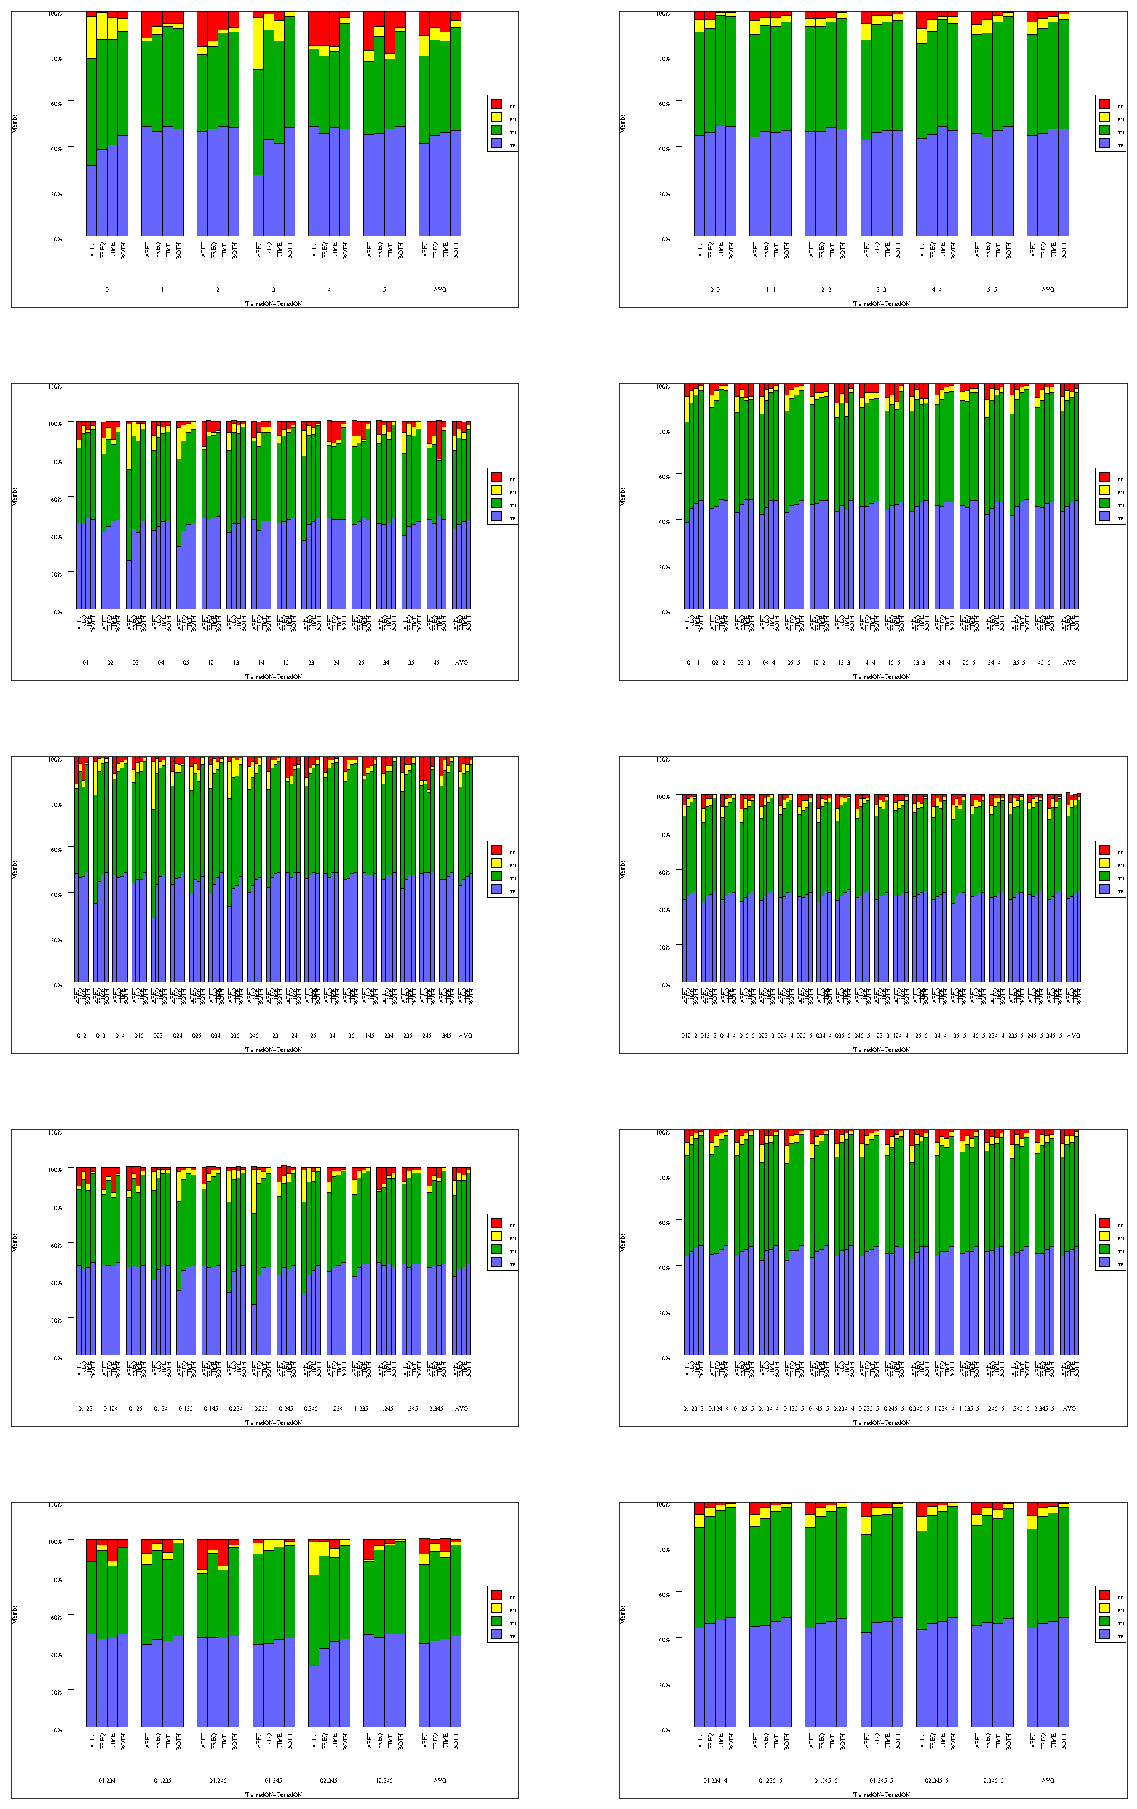

In [6]:
############ RESULT REPORTING ##############
# generate files with stats
bargraph_perf_gen1(6)
bargraph_perf_gen2(6)
bargraph_perf_gen3(6)
bargraph_perf_gen4(6)
bargraph_perf_gen5(6)
# use the bargraph tool to plot graphs from generated files
# -left column cross-accuracy (trained on one, tested on all the others), 
# -right column self-accuracy (trained and tested on the same)
# -each row i represents training only with i surfaces.
# -each stack represents a training group, each bar represents a subfeatureset(AFFT,FREQ,TIME,BOTH)
# -blue,green,yellow,red : TP,TN,FN,FP
plt.figure(figsize=(20,40))
for i in range(5):
    make_bargraphs_from_perf(i)

In [7]:
############ ONLINE TESTING PROCEDURE ##############
# same necessary steps as in training for data preparation
f,l,fd,member,m1,m2 = data_prep(c.validfile)
prefeat = compute_prefeat(f)
features, labels = feature_extraction(prefeat, member, c.validfeatfile, 'validfeat_')
new_labels = label_cleaning(prefeat,labels,member)
X,Y,Yn,Xsp,Ysp = computeXY(features,labels,new_labels,m1,m2,c.validXYfile,c.validXYsplitfile)
surf, surfla = computeXY_persurf(Xsp,Ysp,c.validsurffile,keepind)     # compute per surface data and labels

---------------------------- LOADING DATA and COMPUTING NECESSARY STRUCTS ----------------------------
1 -> f1: (1, 1) (1, 1) (1, 1)
2 -> f2: (1, 1) (1, 1) (1, 1)
3 -> f: (2, 1) (2, 1) (2, 1)
4 -> m1,m2: 1 1 1.0 1.0
5 -> f=f+l: (2, 65000, 4) : [(65000, 4), (65000, 4)]
--------------------------------------- COMPUTING PREFEATURES ----------------------------------------
(2,) : [(65000, 2), (65000, 2)]
---------------------------------------- FEATURE EXTRACTION ------------------------------------------
Features FOUND PRECOMPUTED! Feature Loading DONE in: 1.43796086311 seconds 
features:  (2,) , labels:  (2,)
----------- KEEPING LABEL's PURE (STABLE, SLIP) PHASE PARTS (TRIMMING AROUND CHANGE POINTS)-----------
new_labels:  (2,)
----------------------------- COMPUTING X,Y for CLASSIFIERS' INPUT -----------------------------------
XY files FOUND PRECOMPUTED!
X,Y [0,1,2]:  (3199, 3107) (3199,) (3199, 3107) (3199,) (6398, 3107) (6398,)
Xsp,Ysp [0,1,2]:  (2769, 3107) (2769,) (2769, 3107) (276

(3199,) (2769,) (2769,)
(2650,) (2650,)


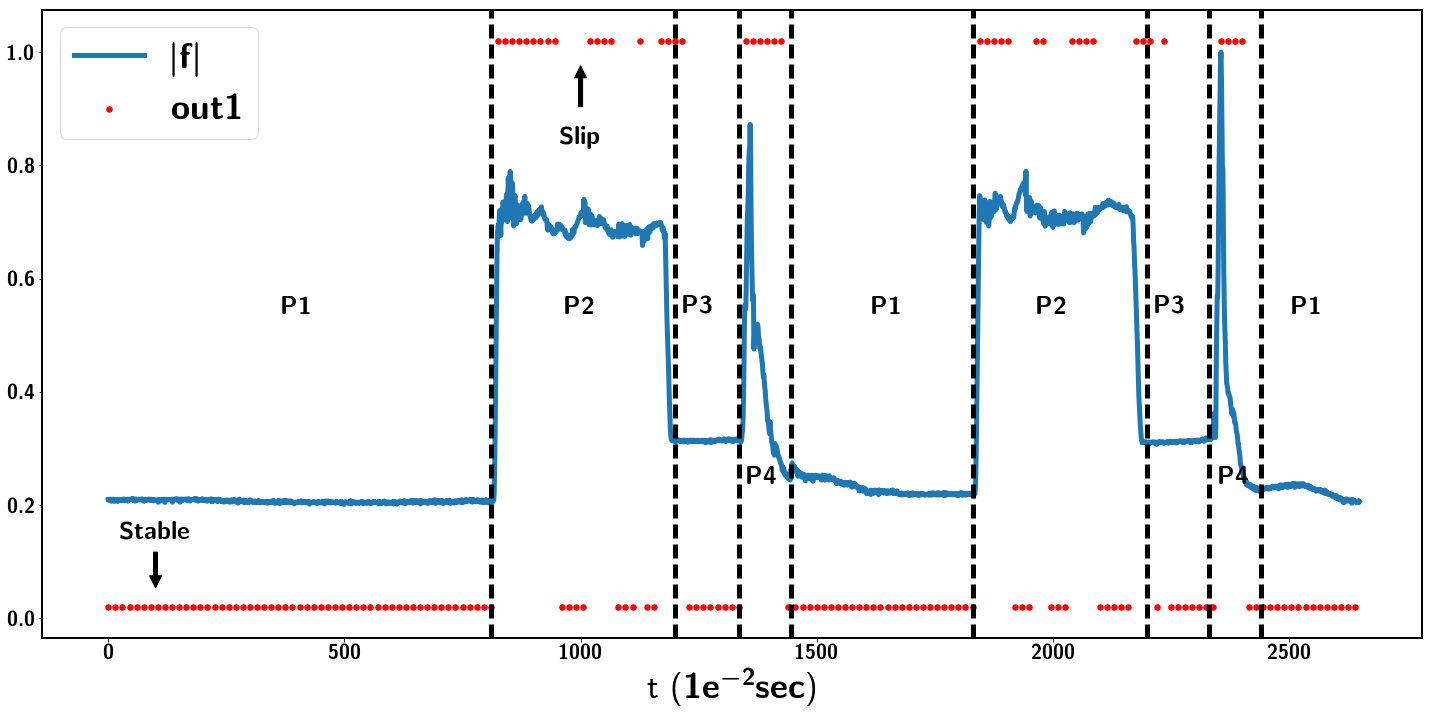

In [8]:
############ VISUALIZING ONLINE TESTING PROCEDURE ##############
window=c.window
subfeats = ['AFFT','FREQ','TIME','BOTH']
feats = ['fnorm','ftfn','fnormftfn']
matplotlib.rcParams['text.usetex'] = True

fileid = filename1(0,3,0,5)
fileidb = filename1(0,0,0,5)
fileid5 = filename5(0,3,0,1,2,3,4,5)
fileid5b = filename5(0,0,0,1,2,3,4,5)
model = np.load(fileid)['model'][0]
modelb = np.load(fileidb)['model'][0]
model5 = np.load(fileid5)['model'][0]
model5b = np.load(fileid5b)['model'][0]
Yout = model.predict(X[0][:,keepind])
Youtb = modelb.predict(Xsp[0][:,-window-2:-window/2-1])
Yout5 = model5.predict(Xsp[0][:,keepind])
Yout5b = model5b.predict(Xsp[0][:,-window-2:-window/2-1])
print Yout.shape, Yout5.shape, Yout5b.shape
plt.rc('text', usetex=True)
plt.rc('axes', linewidth=2)
plt.rc('font', weight='bold')
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
offset = 2000-window
endset = 2650
skipf = 20
skipy = 15
ax = plt.figure(figsize=(20,10))
tf = np.linalg.norm(f[0][offset+window::skipf,:3][:endset],axis=1)
p1, = plt.plot(tf/max(tf),linewidth=5)
ty = Yout[offset/skipf:][:endset]+0.02
print tf.shape, ty.shape
p = plt.scatter(range(len(tf))[::skipy],ty[::skipy],color='red',s=30)
plt.hold
plt.text(100, 0.15, r'\textbf{Stable}', ha="center", va="center", rotation=0,
            size=25)
plt.text(1000, 0.85, r'\textbf{Slip}', ha="center", va="center", rotation=0,
            size=25)
plt.annotate('', fontsize=10, xy=(100, 0.05), xytext=(100, 0.12),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('', xy=(1000, 0.98), xytext=(1000, 0.9),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.text(400, 0.55, r'\textbf{P1}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=810,linestyle='dashed',color='black',linewidth=5)
plt.text(1000, 0.55, r'\textbf{P2}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1200,linestyle='dashed',color='black',linewidth=5)
plt.text(1250, 0.55, r'\textbf{P3}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1335,linestyle='dashed',color='black',linewidth=5)
plt.text(1385, 0.25, r'\textbf{P4}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1445,linestyle='dashed',color='black',linewidth=5)
plt.text(1650, 0.55, r'\textbf{P1}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1830,linestyle='dashed',color='black',linewidth=5)
plt.text(2000, 0.55, r'\textbf{P2}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=2200,linestyle='dashed',color='black',linewidth=5)
plt.text(2250, 0.55, r'\textbf{P3}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=2330,linestyle='dashed',color='black',linewidth=5)
plt.text(2385, 0.25, r'\textbf{P4}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=2440,linestyle='dashed',color='black',linewidth=5)
plt.text(2540, 0.55, r'\textbf{P1}', ha="center", va="center", rotation=0,
            size=25)
plt.xlabel(r't ($1e^{-2} sec$)',fontsize=35)
# plt.yticks([])
plt.legend([p1,p],[r'$|\textbf{f}|$',r'\textbf{out1}'],loc=2, prop={'size': 35})
plt.tick_params(labelsize=20)
plt.tight_layout()
savefig(c.datapath+'validation.pdf', bbox_inches='tight')


In [9]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1.0N_kp3.5_152Hz_validation.mat',keepind)
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1.0N_kp3.5_152Hz_validation_rot.mat',keepind)

Filename for prediction: ati_new_fd1.0N_kp3.5_152Hz_validation.mat
1.34205
1.34205
Accuracy for surface  0 0.827770360481 0.886515353805
TN(stable) and TP(slip) for surface  0 0.822349570201 0.8325 | 0.905444126074 0.87
Accuracy for surface  1 0.843791722296 0.94259012016
TN(stable) and TP(slip) for surface  1 0.836676217765 0.85 | 1.0 0.8925
Accuracy for surface  2 0.877169559413 0.696929238985
TN(stable) and TP(slip) for surface  2 0.842406876791 0.9075 | 0.968481375358 0.46
Accuracy for surface  3 0.865153538051 0.88518024032
TN(stable) and TP(slip) for surface  3 0.848137535817 0.88 | 0.988538681948 0.795
Accuracy for surface  4 0.853137516689 0.837116154873
TN(stable) and TP(slip) for surface  4 0.893982808023 0.8175 | 0.985673352436 0.7075
Accuracy for surface  5 0.853137516689 0.659546061415
TN(stable) and TP(slip) for surface  5 0.985673352436 0.7375 | 0.977077363897 0.3825
Accuracy for dataset    0.853360035603 0.81797952826
TN(stable) and TP(slip) for dataset  0.871537726839 

In [10]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1.5N_kp3_152Hz_validation.mat',keepind)
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1.5N_kp3_152Hz_validation_rot.mat',keepind)

Filename for prediction: ati_new_fd1.5N_kp3_152Hz_validation.mat
2.02426
2.02426
Accuracy for surface  0 0.730307076101 0.931909212283
TN(stable) and TP(slip) for surface  0 0.593123209169 0.85 | 0.939828080229 0.925
Accuracy for surface  1 0.809078771696 0.921228304406
TN(stable) and TP(slip) for surface  1 0.779369627507 0.835 | 0.985673352436 0.865
Accuracy for surface  2 0.84779706275 0.88785046729
TN(stable) and TP(slip) for surface  2 0.793696275072 0.895 | 0.916905444126 0.8625
Accuracy for surface  3 0.865153538051 0.891855807744
TN(stable) and TP(slip) for surface  3 0.828080229226 0.8975 | 0.97994269341 0.815
Accuracy for surface  4 0.893190921228 0.883845126836
TN(stable) and TP(slip) for surface  4 0.865329512894 0.9175 | 0.982808022923 0.7975
Accuracy for surface  5 0.937249666222 0.668891855808
TN(stable) and TP(slip) for surface  5 1.0 0.8825 | 1.0 0.38
Accuracy for dataset    0.847129506008 0.864263462394
TN(stable) and TP(slip) for dataset  0.809933142311 0.87958333333

In [11]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1.0N_kp3.5_326Hz_validation.mat',keepind)
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1.0N_kp3.5_326Hz_validation_rot.mat',keepind)

Filename for prediction: ati_new_fd1.0N_kp3.5_326Hz_validation.mat
1.51563
1.51563
Accuracy for surface  0 0.763684913218 0.754339118825
TN(stable) and TP(slip) for surface  0 0.707736389685 0.8125 | 0.716332378223 0.7875
Accuracy for surface  1 0.84779706275 0.806408544726
TN(stable) and TP(slip) for surface  1 0.862464183381 0.835 | 0.957020057307 0.675
Accuracy for surface  2 0.81041388518 0.576769025367
TN(stable) and TP(slip) for surface  2 0.696275071633 0.91 | 0.89111747851 0.3025
Accuracy for surface  3 0.899866488652 0.801068090788
TN(stable) and TP(slip) for surface  3 0.916905444126 0.885 | 0.965616045845 0.6575
Accuracy for surface  4 0.901201602136 0.58611481976
TN(stable) and TP(slip) for surface  4 0.957020057307 0.8525 | 0.908309455587 0.305
Accuracy for surface  5 0.839786381842 0.461949265688
TN(stable) and TP(slip) for surface  5 0.991404011461 0.7075 | 0.825214899713 0.145
Accuracy for dataset    0.843791722296 0.664441477526
TN(stable) and TP(slip) for dataset  0.8

In [12]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1.5N_kp3_326Hz_validation.mat',keepind)
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1.5N_kp3_326Hz_validation_rot.mat',keepind)

Filename for prediction: ati_new_fd1.5N_kp3_326Hz_validation.mat
1.8981
1.8981
Accuracy for surface  0 0.798397863818 0.921228304406
TN(stable) and TP(slip) for surface  0 0.773638968481 0.82 | 0.951289398281 0.895
Accuracy for surface  1 0.694259012016 0.875834445928
TN(stable) and TP(slip) for surface  1 0.527220630372 0.84 | 0.868194842407 0.8825
Accuracy for surface  2 0.767690253672 0.822429906542
TN(stable) and TP(slip) for surface  2 0.63323782235 0.885 | 0.776504297994 0.8625
Accuracy for surface  3 0.841121495327 0.881174899866
TN(stable) and TP(slip) for surface  3 0.776504297994 0.8975 | 0.991404011461 0.785
Accuracy for surface  4 0.883845126836 0.842456608812
TN(stable) and TP(slip) for surface  4 0.879656160458 0.8875 | 0.988538681948 0.715
Accuracy for surface  5 0.922563417891 0.728971962617
TN(stable) and TP(slip) for surface  5 0.994269340974 0.86 | 1.0 0.4925
Accuracy for dataset    0.81797952826 0.845349354695
TN(stable) and TP(slip) for dataset  0.764087870105 0.86

In [13]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1.0N_kp3.5_836Hz_validation.mat',keepind)
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1.0N_kp3.5_836Hz_validation_rot.mat',keepind)

Filename for prediction: ati_new_fd1.0N_kp3.5_836Hz_validation.mat
1.42474
1.42474
Accuracy for surface  0 0.731642189586 0.757009345794
TN(stable) and TP(slip) for surface  0 0.613180515759 0.835 | 0.816618911175 0.705
Accuracy for surface  1 0.801068090788 0.71829105474
TN(stable) and TP(slip) for surface  1 0.76217765043 0.835 | 0.853868194842 0.6
Accuracy for surface  2 0.845126835781 0.647530040053
TN(stable) and TP(slip) for surface  2 0.830945558739 0.8575 | 0.965616045845 0.37
Accuracy for surface  3 0.859813084112 0.706275033378
TN(stable) and TP(slip) for surface  3 0.859598853868 0.86 | 0.914040114613 0.525
Accuracy for surface  4 0.88518024032 0.630173564753
TN(stable) and TP(slip) for surface  4 0.908309455587 0.865 | 0.914040114613 0.3825
Accuracy for surface  5 0.88518024032 0.622162883845
TN(stable) and TP(slip) for surface  5 0.988538681948 0.795 | 0.985673352436 0.305
Accuracy for dataset    0.834668446818 0.680240320427
TN(stable) and TP(slip) for dataset  0.82712511

In [14]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1.5N_kp3.5_836Hz_validation.mat',keepind)
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1.5N_kp3.5_836Hz_validation_rot.mat',keepind)

Filename for prediction: ati_new_fd1.5N_kp3.5_836Hz_validation.mat
7.66321
7.66321
Accuracy for surface  0 0.769477054429 0.93916755603
TN(stable) and TP(slip) for surface  0 0.716332378223 0.801020408163 | 0.951289398281 0.931972789116
Accuracy for surface  1 0.787620064034 0.938100320171
TN(stable) and TP(slip) for surface  1 0.767908309456 0.799319727891 | 0.974212034384 0.916666666667
Accuracy for surface  2 0.84204909285 0.870864461046
TN(stable) and TP(slip) for surface  2 0.842406876791 0.841836734694 | 0.977077363897 0.807823129252
Accuracy for surface  3 0.801494130203 0.812166488794
TN(stable) and TP(slip) for surface  3 0.828080229226 0.785714285714 | 0.885386819484 0.768707482993
Accuracy for surface  4 0.885805763074 0.832443970117
TN(stable) and TP(slip) for surface  4 0.89111747851 0.882653061224 | 0.848137535817 0.823129251701
Accuracy for surface  5 0.769477054429 0.542155816435
TN(stable) and TP(slip) for surface  5 0.670487106017 0.828231292517 | 0.997134670487 0.272

In [15]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1N_kp3_nofilt_validation.mat',keepind)
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1N_kp3_nofilt_validation_rot.mat',keepind)

Filename for prediction: ati_new_fd1N_kp3_nofilt_validation.mat
1.44638
1.44638
Accuracy for surface  0 0.732977303071 0.929238985314
TN(stable) and TP(slip) for surface  0 0.621776504298 0.83 | 0.965616045845 0.8975
Accuracy for surface  1 0.754339118825 0.943925233645
TN(stable) and TP(slip) for surface  1 0.670487106017 0.8275 | 0.994269340974 0.9
Accuracy for surface  2 0.771695594126 0.827770360481
TN(stable) and TP(slip) for surface  2 0.690544412607 0.8425 | 0.971346704871 0.7025
Accuracy for surface  3 0.866488651535 0.86782376502
TN(stable) and TP(slip) for surface  3 0.839541547278 0.89 | 0.982808022923 0.7675
Accuracy for surface  4 0.881174899866 0.763684913218
TN(stable) and TP(slip) for surface  4 0.845272206304 0.9125 | 0.89111747851 0.6525
Accuracy for surface  5 0.886515353805 0.527369826435
TN(stable) and TP(slip) for surface  5 0.888252148997 0.885 | 1.0 0.115
Accuracy for dataset    0.815531820205 0.809968847352
TN(stable) and TP(slip) for dataset  0.759312320917 0.

In [16]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1.5N_kp3_nofilt_validation.mat',keepind)
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1.5N_kp3_nofilt_validation_rot.mat',keepind)

Filename for prediction: ati_new_fd1.5N_kp3_nofilt_validation.mat
1.84994
1.84994
Accuracy for surface  0 0.71562082777 0.903871829105
TN(stable) and TP(slip) for surface  0 0.613180515759 0.805 | 1.0 0.82
Accuracy for surface  1 0.655540720961 0.893190921228
TN(stable) and TP(slip) for surface  1 0.467048710602 0.82 | 0.885386819484 0.9
Accuracy for surface  2 0.863818424566 0.866488651535
TN(stable) and TP(slip) for surface  2 0.839541547278 0.885 | 0.997134670487 0.7525
Accuracy for surface  3 0.798397863818 0.90520694259
TN(stable) and TP(slip) for surface  3 0.696275071633 0.8875 | 1.0 0.8225
Accuracy for surface  4 0.913217623498 0.874499332443
TN(stable) and TP(slip) for surface  4 0.931232091691 0.8975 | 1.0 0.765
Accuracy for surface  5 0.889185580774 0.599465954606
TN(stable) and TP(slip) for surface  5 0.942693409742 0.8425 | 1.0 0.25
Accuracy for dataset    0.805963506898 0.840453938585
TN(stable) and TP(slip) for dataset  0.748328557784 0.85625 | 0.980420248329 0.718333333

## Scaled Version of one of the above on the following ranges (0.1, 0.5, 1.0, 2.0, 5.0, 20.0)

In [17]:
for sc in [0.1, 0.5, 1.0, 2.0, 5.0, 20.0]:
    print "-------- SCALING = ",sc,"--------"
    ####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
    prediction('ati_new_fd1.5N_kp3_152Hz_validation.mat',keepind=keepind,scale=sc)
    ####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
    prediction('ati_new_fd1.5N_kp3_152Hz_validation_rot.mat',keepind=keepind,scale=sc)

-------- SCALING =  0.1 --------
Filename for prediction: ati_new_fd1.5N_kp3_152Hz_validation.mat
2.02426
0.202426
Accuracy for surface  0 0.874499332443 0.576769025367
TN(stable) and TP(slip) for surface  0 0.89111747851 0.86 | 0.21776504298 0.89
Accuracy for surface  1 0.902536715621 0.783711615487
TN(stable) and TP(slip) for surface  1 0.968481375358 0.845 | 0.724928366762 0.835
Accuracy for surface  2 0.931909212283 0.345794392523
TN(stable) and TP(slip) for surface  2 0.991404011461 0.88 | 0.025787965616 0.625
Accuracy for surface  3 0.915887850467 0.779706275033
TN(stable) and TP(slip) for surface  3 0.988538681948 0.8525 | 0.707736389685 0.8425
Accuracy for surface  4 0.894526034713 0.75567423231
TN(stable) and TP(slip) for surface  4 0.873925501433 0.9125 | 0.896848137536 0.6325
Accuracy for surface  5 0.986648865154 0.710280373832
TN(stable) and TP(slip) for surface  5 1.0 0.975 | 0.939828080229 0.51
Accuracy for dataset    0.91766800178 0.658655985759
TN(stable) and TP(slip) 

Accuracy for dataset    0.791054739653 0.928571428571
TN(stable) and TP(slip) for dataset  0.648519579752 0.915416666667 | 0.968003820439 0.894166666667
Filename for prediction: ati_new_fd1.5N_kp3_152Hz_validation_rot.mat
1.39025
2.7805
Accuracy for surface  0 0.831401475237 0.884088514226
TN(stable) and TP(slip) for surface  0 0.823315118397 0.8425 | 0.892531876138 0.8725
Accuracy for surface  1 0.652265542677 0.951527924131
TN(stable) and TP(slip) for surface  1 0.515482695811 0.84 | 0.96174863388 0.9375
Accuracy for surface  2 0.708113804004 0.801896733404
TN(stable) and TP(slip) for surface  2 0.664845173042 0.7675 | 0.972677595628 0.5675
Accuracy for surface  3 0.873551106428 0.969441517387
TN(stable) and TP(slip) for surface  3 0.863387978142 0.8875 | 1.0 0.9275
Accuracy for surface  4 0.656480505796 0.898840885142
TN(stable) and TP(slip) for surface  4 0.431693989071 0.965 | 0.945355191257 0.835
Accuracy for surface  5 0.81875658588 0.68387776607
TN(stable) and TP(slip) for surf

## Check the training forces and compare them with testing ones (2.86 1.35 2.12 1.68)

In [18]:
printit = False
f,_,_,_,_,_ = data_prep(c.datafile,printit=printit)                        # read training input force
pf = compute_prefeat(f,printit=printit)                                  # compute corresponding prefeatures
fv,_,_,_,_,_ = data_prep(c.validfile,printit=printit)                      # read validation input force
pfv = compute_prefeat(fv,printit=printit)                                # compute corresponding prefeatures

atifiles = ['ati_new_fd1.0N_kp3.5_152Hz_validation.mat',
            'ati_new_fd1.0N_kp3.5_152Hz_validation_rot.mat',
            'ati_new_fd1.5N_kp3_152Hz_validation.mat',
            'ati_new_fd1.5N_kp3_152Hz_validation_rot.mat',
            'ati_new_fd1.0N_kp3.5_326Hz_validation.mat',
            'ati_new_fd1.0N_kp3.5_326Hz_validation_rot.mat',
            'ati_new_fd1.5N_kp3_326Hz_validation.mat',
            'ati_new_fd1.5N_kp3_326Hz_validation_rot.mat',
            'ati_new_fd1.0N_kp3.5_836Hz_validation.mat',
            'ati_new_fd1.0N_kp3.5_836Hz_validation_rot.mat',
            'ati_new_fd1.5N_kp3.5_836Hz_validation.mat',
            'ati_new_fd1.5N_kp3.5_836Hz_validation_rot.mat',
            'ati_new_fd1N_kp3_nofilt_validation.mat',
            'ati_new_fd1N_kp3_nofilt_validation_rot.mat',
            'ati_new_fd1.5N_kp3_nofilt_validation.mat',
            'ati_new_fd1.5N_kp3_nofilt_validation_rot.mat']
atiftr = []
atifrt = []
for filen in atifiles:
    tf,_,_,_,_,_ = data_prep(c.datapath+filen,k=1,printit=printit)
    ptf = compute_prefeat(tf,printit=printit)
    if filen[-7:-4] == 'rot':
        atifrt.append(ptf)
    else:
        atiftr.append(ptf)
atiftr = np.array(atiftr).flatten()
atifrt = np.array(atifrt).flatten()

plist = [pf, pfv, atiftr, atifrt]
pname = ['train', 'valid','atitran','atirot']
print pf.shape, pfv.shape, atiftr.shape, atifrt.shape
mf, mfst, mfsl = np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4))
print 'datasetname: [all/stable/slip:[0:mean, 1:max, 2:min, 3:std]]'
for ind in range(len(plist)):
    pt = plist[ind]
    # 0:mean, 1:max, 2:min, 3:std
    for p in range(len(pt)):
        mf[ind,0] += np.mean(pt[p][:,0])
        mf[ind,1] += np.max(pt[p][:,0])
        mf[ind,2] += np.min(pt[p][:,0])
        mf[ind,3] += np.std(pt[p][:,0])
        stind = pt[p][:,1]==0
        slind = pt[p][:,1]==1
        mfst[ind,0] += np.mean(pt[p][stind,0])
        mfst[ind,1] += np.max(pt[p][stind,0])
        mfst[ind,2] += np.min(pt[p][stind,0])
        mfst[ind,3] += np.std(pt[p][stind,0])
        mfsl[ind,0] += np.mean(pt[p][slind,0])
        mfsl[ind,1] += np.max(pt[p][slind,0])
        mfsl[ind,2] += np.min(pt[p][slind,0])
        mfsl[ind,3] += np.std(pt[p][slind,0])
    mf[ind,0] /= len(plist[ind])
    mf[ind,1] /= len(plist[ind])
    mf[ind,2] /= len(plist[ind])
    mf[ind,3] /= len(plist[ind])
    mfst[ind,0] /= len(plist[ind])
    mfst[ind,1] /= len(plist[ind])
    mfst[ind,2] /= len(plist[ind])
    mfst[ind,3] /= len(plist[ind])
    mfsl[ind,0] /= len(plist[ind])
    mfsl[ind,1] /= len(plist[ind])
    mfsl[ind,2] /= len(plist[ind])
    mfsl[ind,3] /= len(plist[ind])
    print pname[ind], mf[ind], mfst[ind], mfsl[ind]

(72,) (2,) (48,) (48,)
datasetname: [all/stable/slip:[0:mean, 1:max, 2:min, 3:std]]
train [ 2.86251015  5.09840423  1.49469399  0.98215772] [ 2.18675048  3.03727431  1.72562893  0.28885944] [ 3.66916912  5.09562958  1.51392494  0.8716188 ]
valid [ 1.34931022  3.08346999  0.6870942   0.76446083] [ 0.7360613   1.01612632  0.6870942   0.07938595] [ 1.64921946  3.08346999  0.69021954  0.76977593]
atitran [ 1.7081888   4.31136074  0.49442186  0.64149739] [ 1.47028108  1.67330645  1.22426491  0.13014016] [ 1.92579317  4.31136074  0.49605079  0.80594714]
atirot [ 1.66960896  2.3169749   1.01502636  0.23922276] [ 1.59671116  1.85347776  1.3185732   0.12934402] [ 1.77400117  2.31319775  1.06879374  0.26144718]
